<a href="https://colab.research.google.com/github/7rohit/Direct-Marketing-Efficacy-BLR/blob/main/BLR_Direct_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysing Efficacy of Direct Marketing**

Building a binary classification model using Bayesian Logistic Regression to predict whether or not a customer will subscribe a term deposit after the direct marketing by bank.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [36]:
df = pd.read_csv('bank-marketing.csv')

In [37]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [38]:
def replace_education(education):
    #This function codes the highest education attained.
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2

In [39]:
df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))

In [40]:
month_no = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7, 'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}
day_no = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}
outcome_no = {'yes': 1, 'no': 0}

df['month'] = df['month'].apply(lambda x: month_no[x])
df['day_of_week'] = df['day_of_week'].apply(lambda x: day_no[x])
df['y'] = df['y'].apply(lambda x: outcome_no[x])

In [41]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,4,4,3,0,0,0,2,5,1,261,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,0
1,57,8,4,6,2,0,0,2,5,1,149,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,0
2,37,8,4,6,0,1,0,2,5,1,226,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,0
3,40,11,4,4,0,0,0,2,5,1,151,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,0
4,56,8,4,6,0,0,1,2,5,1,307,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,0


**Logical Regression with One Independent Variable**

Converting the data in the right format and centering it to help in sampling.

Deterministic variable θ is the output of the logistic function applied to the μ variable and bd is the boundary function.

In [42]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
data.corr()['outcome'].sort_values(ascending=False)

outcome        1.000000
duration       0.405274
previous       0.230181
month          0.037187
education      0.035848
age            0.030399
day_of_week    0.010051
housing        0.009552
loan          -0.005038
job           -0.023020
marital       -0.026302
campaign      -0.066357
default       -0.099324
poutcome      -0.122089
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64

In [43]:
y_simple = data['outcome']
x_n = 'duration' 
x_0 = data[x_n].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 139 seconds.


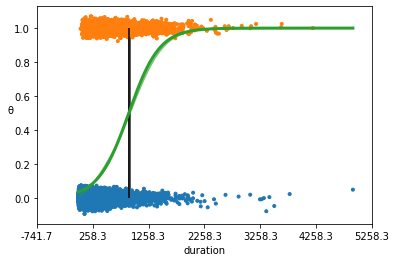

In [48]:
theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
az.plot_hdi(x_c, trace_simple['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

The above plot shows non-subscription vs. subscription, i.e., y = 0 vs y = 1.

The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription.

The boundary decision is represented as a (black) vertical line. According to the boundary decision, the values of duration to the left correspond to y = 0 (non-subscription), and the values to the right to y = 1 (subscription).

In [49]:
az.summary(trace_simple, var_names=['α', 'β'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-2.349,0.019,-2.382,-2.313,0.0,0.0,1519.0,1383.0,1.0
β,0.004,0.000,0.004,0.004,0.0,0.0,1409.0,1082.0,1.0


In [51]:
ppc = pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

In [52]:
print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

Accuracy of the simplest model: 0.8931727687676022
f1 score of the simplest model: 0.2592592592592593


Correlation of Data

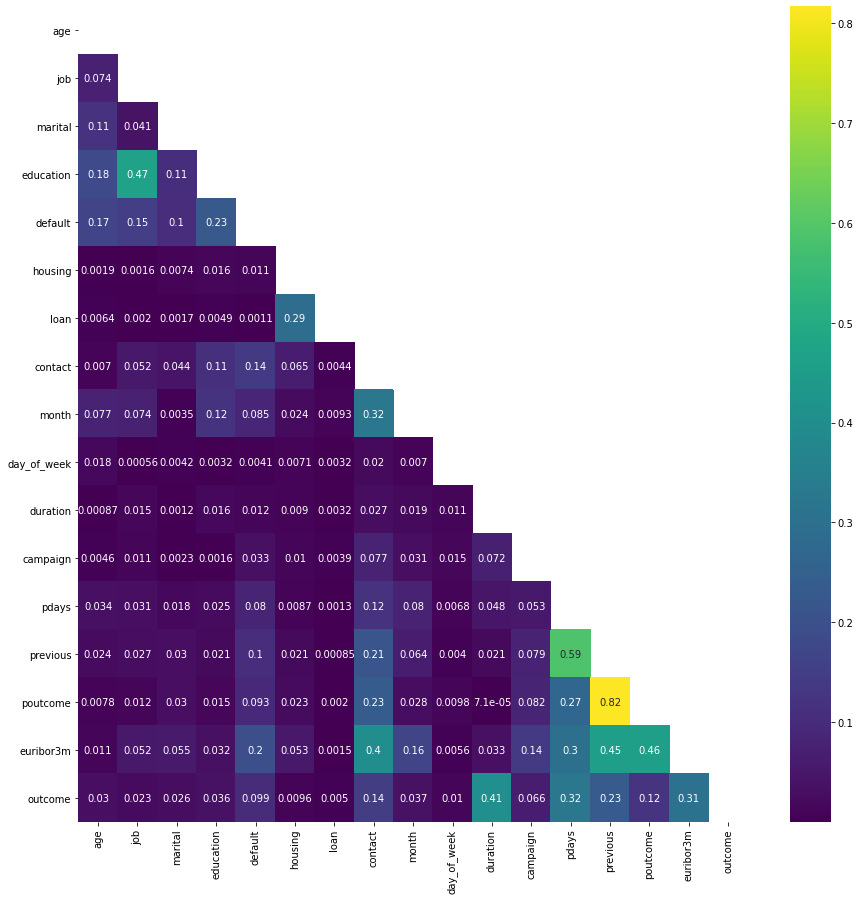

In [53]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [54]:
data['age'] = data['age'] / 10 # Scaling age by 10 for the model convergence.
data['age2'] = np.square(data['age'])

Define logistic regression model using PyMC3 GLM method with multiple independent variables.

In [55]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2883 seconds.


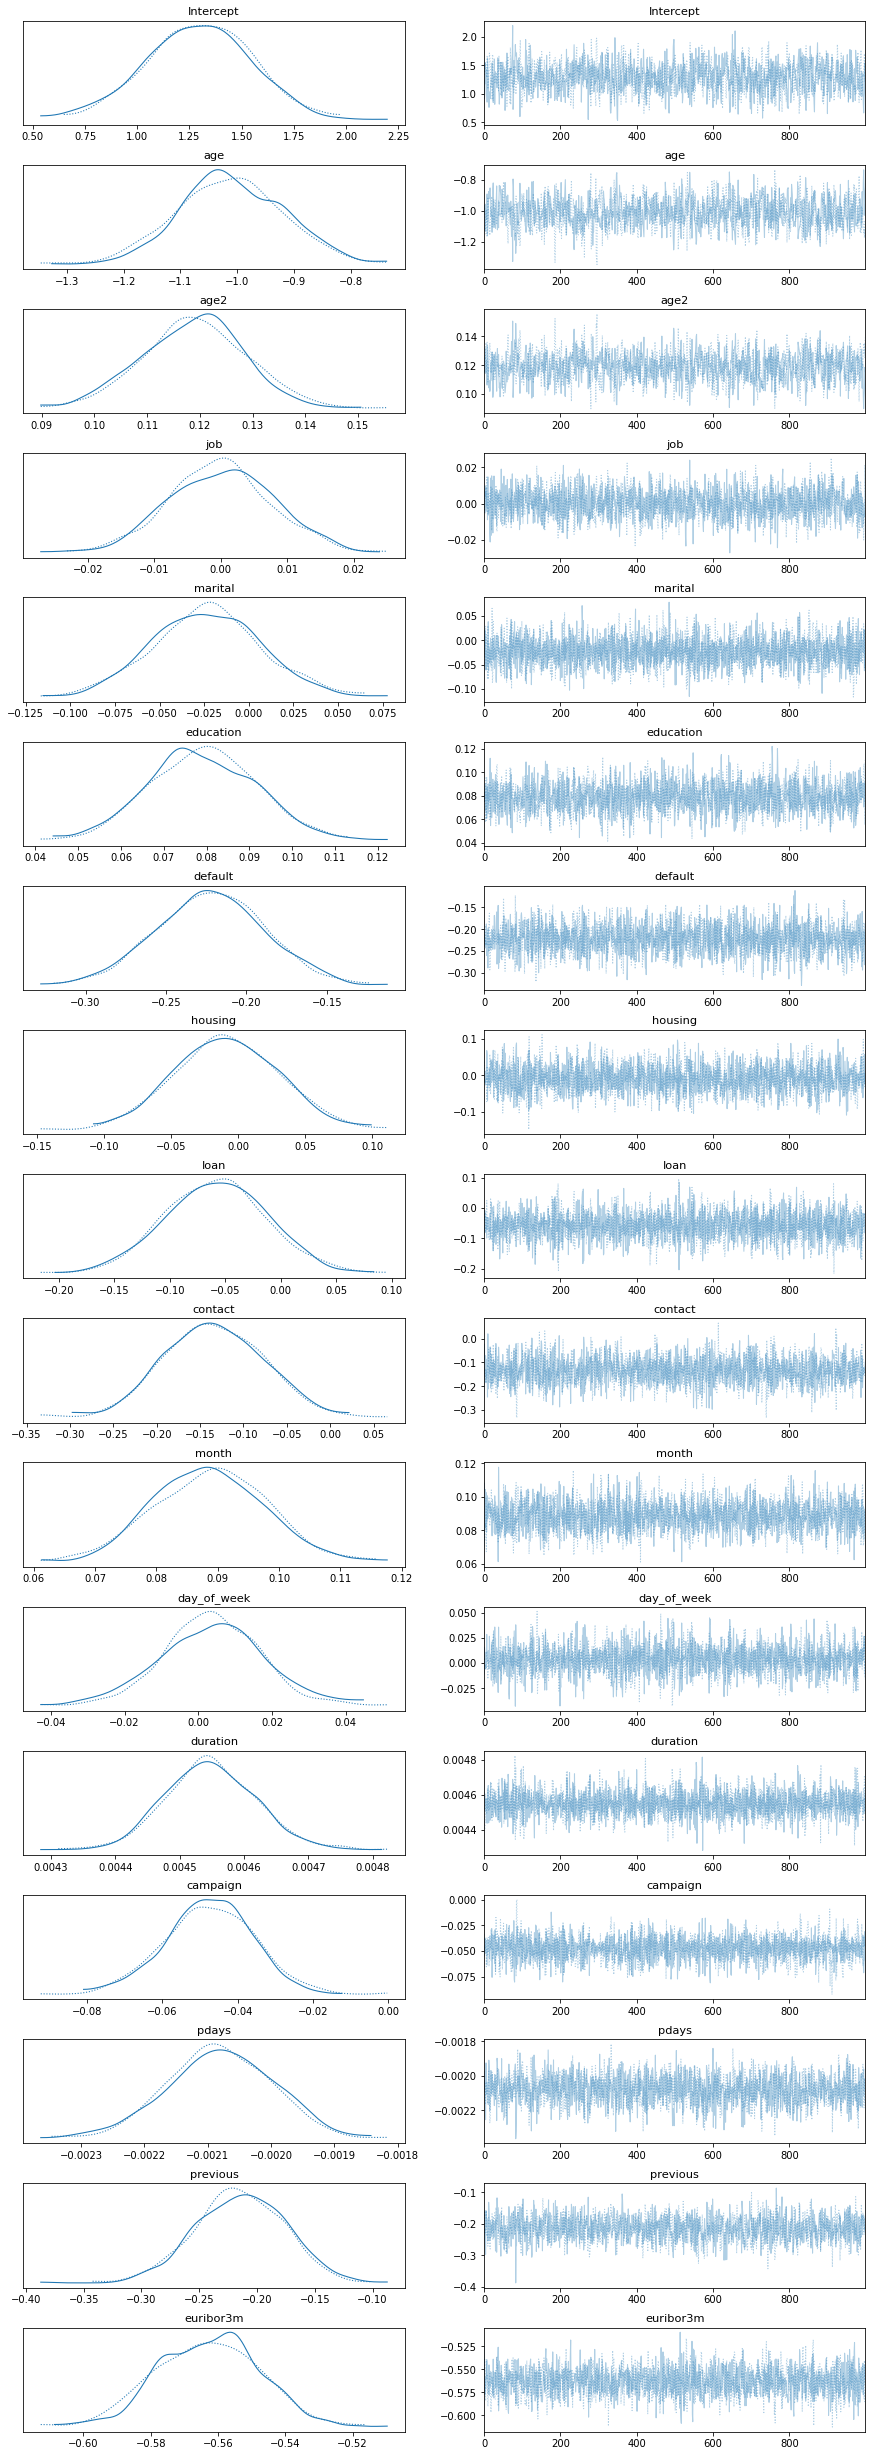

In [56]:
az.plot_trace(trace);

In [57]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 1., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 5., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 8., 4.)

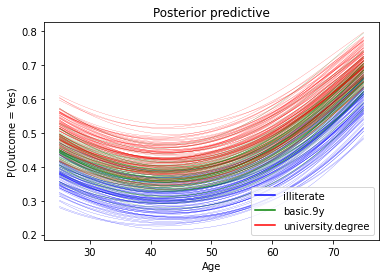

In [58]:
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(['lm'], [], color='b', label='illiterate')
green_line = mlines.Line2D(['lm2'], [], color='g', label='basic.9y') 
red_line = mlines.Line2D(['lm3'], [], color='r', label='university.degree')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Outcome = Yes)")
plt.xlabel("Age")
plt.show();

Estimating Odds Ration

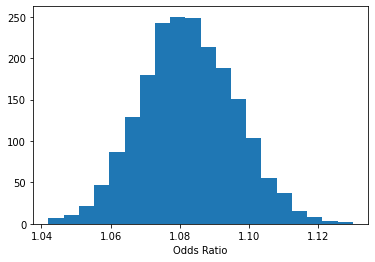

In [60]:
b = trace['education']
plt.hist(np.exp(b), bins=20)
plt.xlabel("Odds Ratio")
plt.show();

In [61]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(1.056 < Odds Ratio < 1.110) = 0.95


"With probability 0.95 the odds ratio is greater than 1.055 and less than 1.108, so the education effect takes place because a person with a higher education level has at least 1.055 higher probability to subscribe to a term deposit than a person with a lower education level, while holding all the other variables constant."

In [62]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
Intercept,1.296,0.252,0.785,1.729,0.007,0.005,1256.0,1507.0,1.0,3.654649,265.464880
age,-1.011,0.092,-1.191,-0.848,0.003,0.002,1082.0,1387.0,1.0,0.363855,-63.614506
age2,0.119,0.010,0.101,0.137,0.000,0.000,1104.0,1323.0,1.0,1.126370,12.636992
job,0.000,0.008,-0.014,0.015,0.000,0.000,1760.0,1573.0,1.0,1.000000,0.000000
marital,-0.023,0.030,-0.080,0.034,0.001,0.001,3509.0,1441.0,1.0,0.977262,-2.273752
education,0.079,0.013,0.057,0.104,0.000,0.000,1845.0,1505.0,1.0,1.082204,8.220432
default,-0.222,0.033,-0.283,-0.158,0.001,0.000,2840.0,1625.0,1.0,0.800915,-19.908464
housing,-0.008,0.038,-0.078,0.065,0.001,0.001,2736.0,1566.0,1.0,0.992032,-0.796809
loan,-0.058,0.046,-0.142,0.030,0.001,0.001,3514.0,1323.0,1.0,0.943650,-5.635005
contact,-0.134,0.057,-0.242,-0.032,0.001,0.001,2478.0,1486.0,1.0,0.874590,-12.540994


“With a one unit increase in education, the odds of subscribing to a term deposit increases by 8%. Similarly, for a one unit increase in euribor3m, the odds of subscribing to a term deposit decreases by 43%, while holding all the other independent variables constant.”

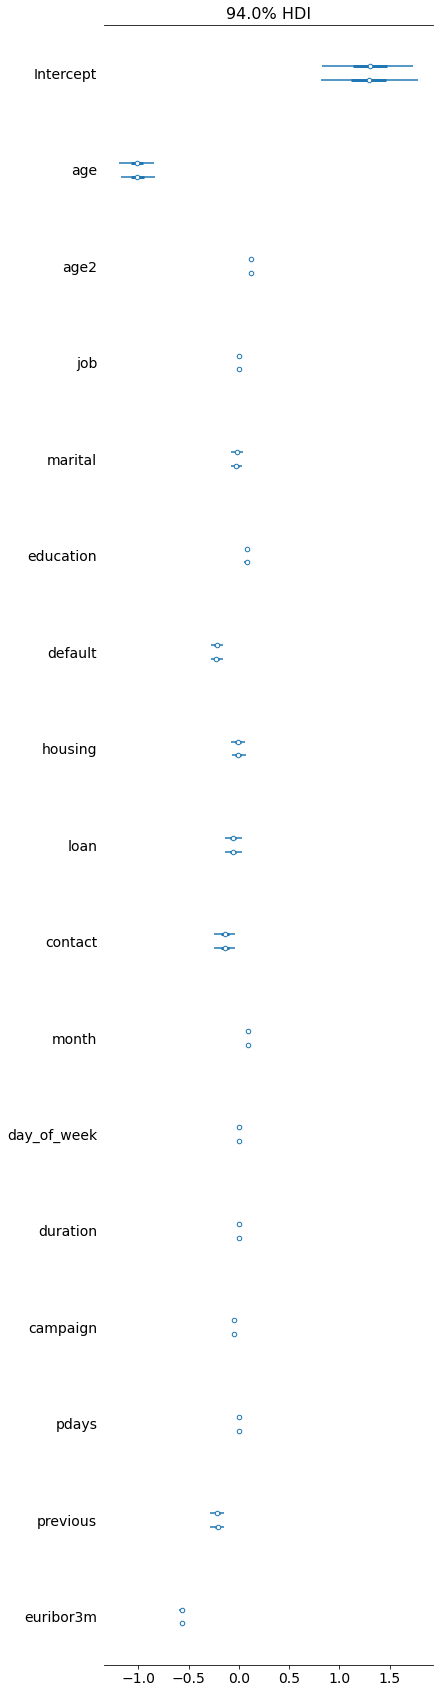

In [63]:
az.plot_forest(trace);

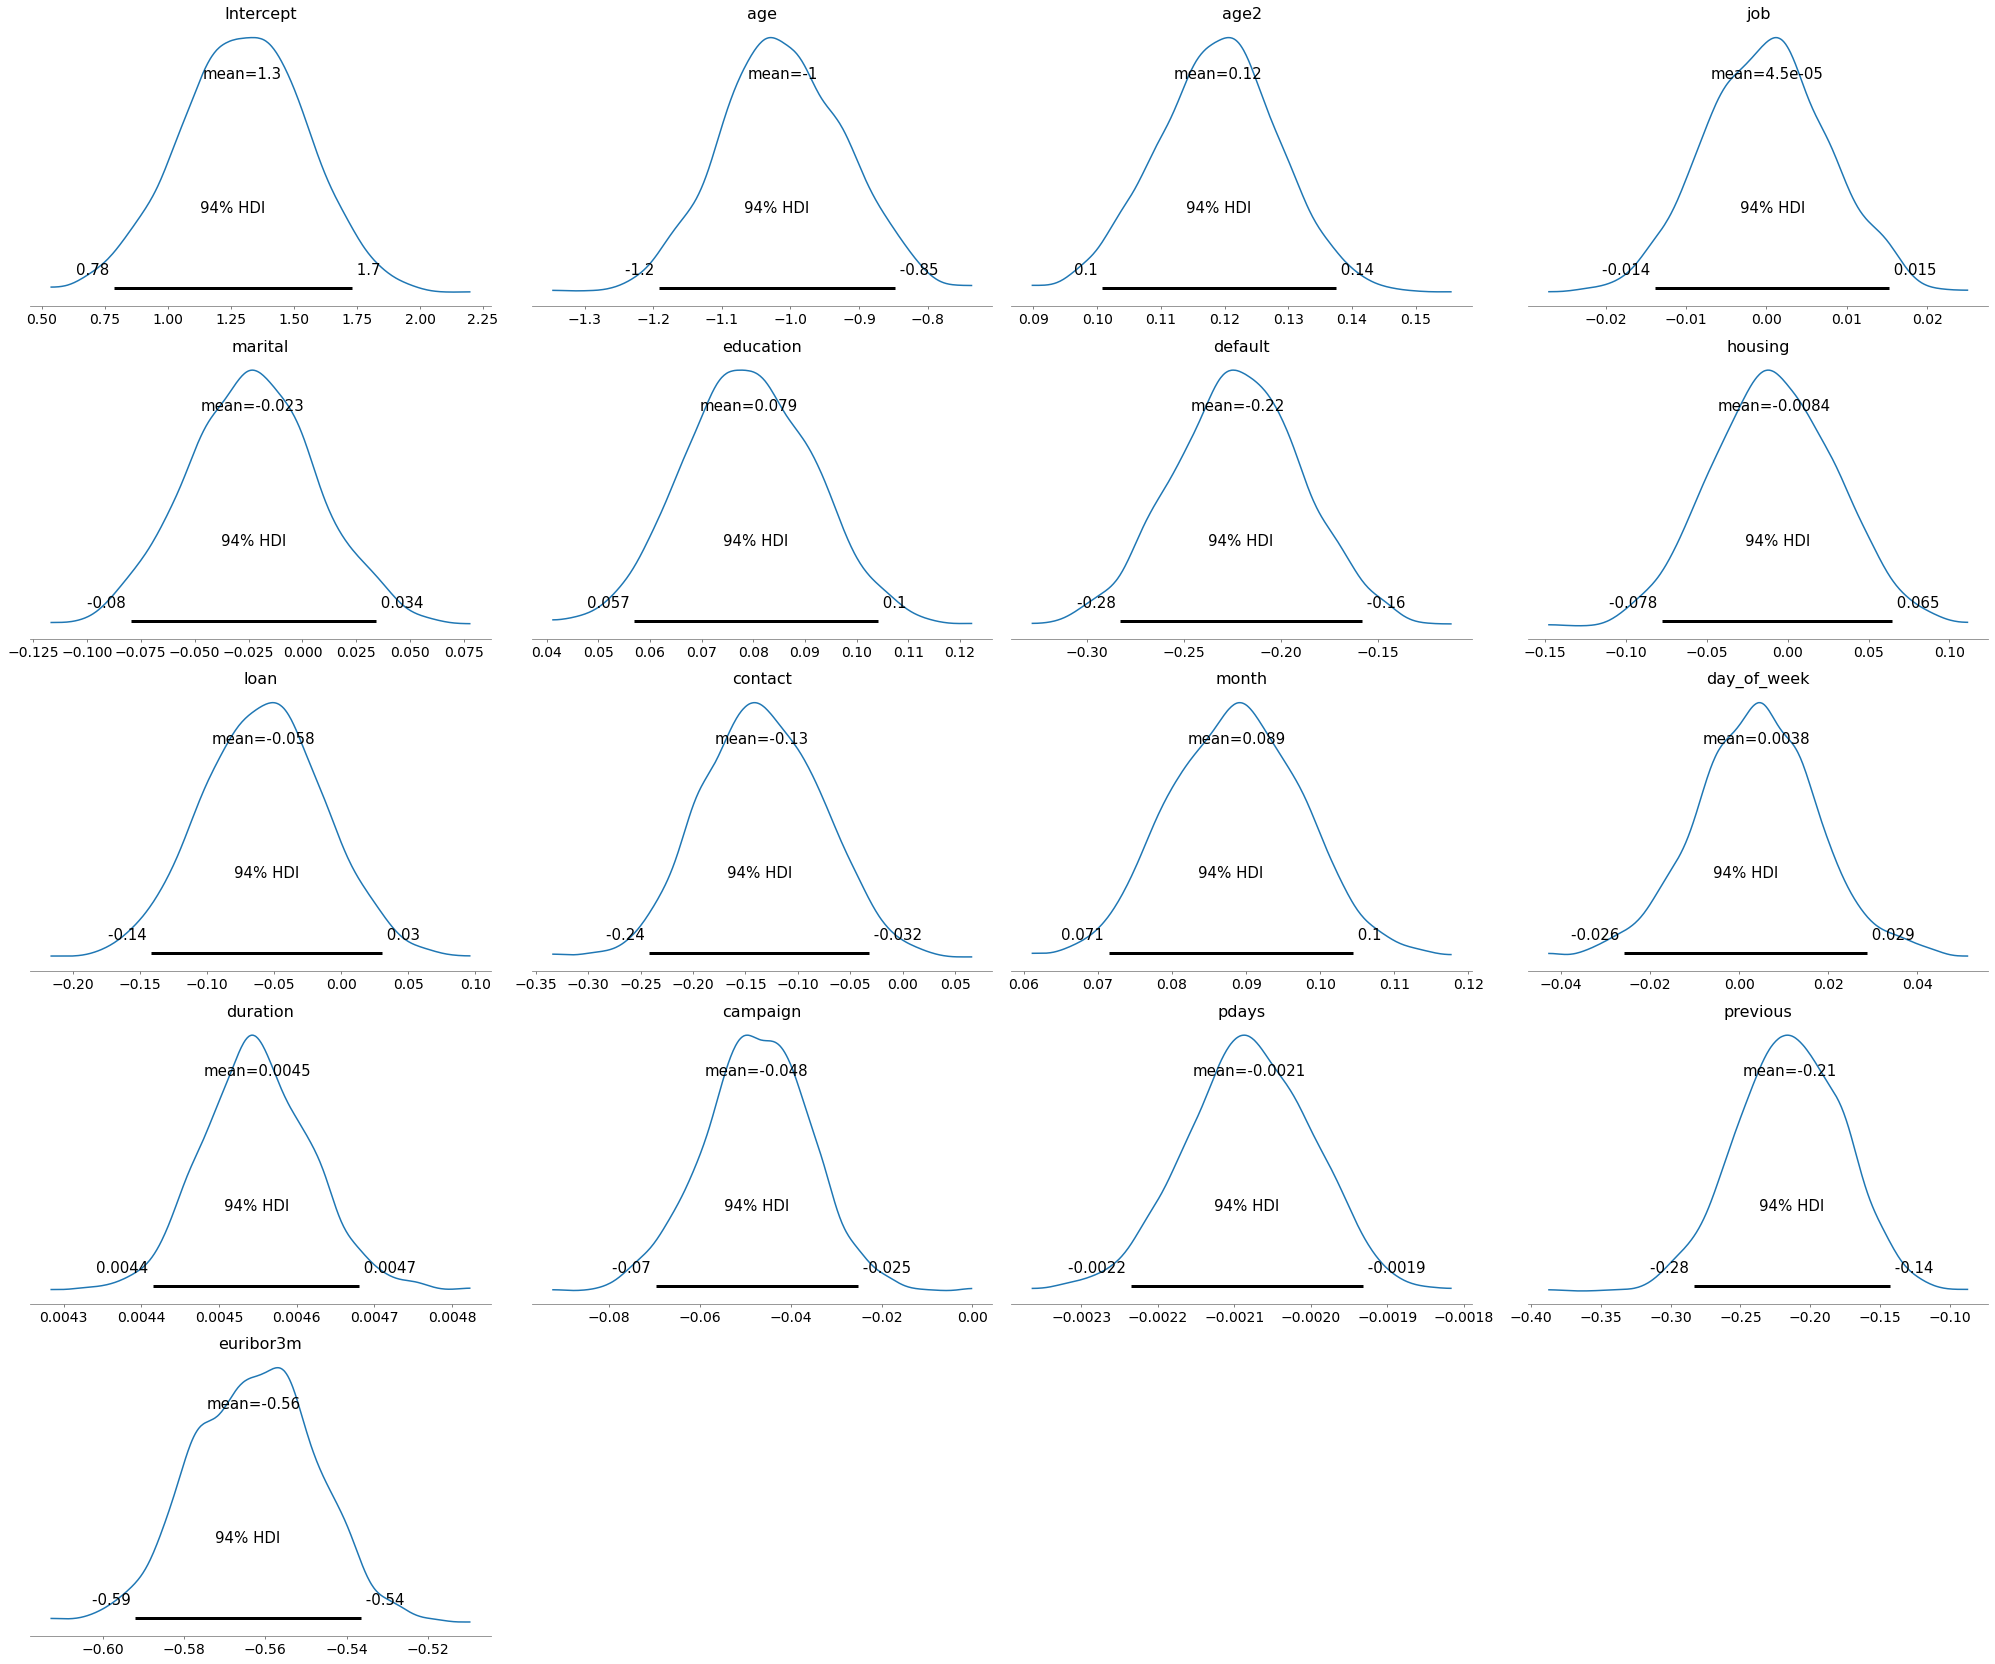

In [64]:
pm.plot_posterior(trace);

**Compare models using Widely-applicable Information Criterion (WAIC)**

WAIC is a measure of model fit that can be applied to Bayesian models and that works when the parameter estimation is done using numerical techniques.

In [65]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('outcome ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

models_lin, traces_lin = run_models(data, 3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1616 seconds.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2829 seconds.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(age, 3), np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9914 seconds.


In [68]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

                                                    rank         waic  \
       Intercept ~ Flat\n             age ~ Nor...     0 -9136.493381   
       Intercept ~ Flat\n             age ~ Nor...     1 -9151.339736   
  Intercept ~ Flat\n        age ~ Normal\n     ...     2 -9224.340923   

                                                       p_waic     d_waic  \
       Intercept ~ Flat\n             age ~ Nor...  20.315638   0.000000   
       Intercept ~ Flat\n             age ~ Nor...  19.346880  14.846354   
  Intercept ~ Flat\n        age ~ Normal\n     ...  17.777843  87.847542   

                                                      weight          se  \
       Intercept ~ Flat\n             age ~ Nor...  0.902506  113.907384   
       Intercept ~ Flat\n             age ~ Nor...  0.050198  113.875981   
  Intercept ~ Flat\n        age ~ Normal\n     ...  0.047296  114.121552   

                                                          dse  warning  \
       Intercept ~ Flat

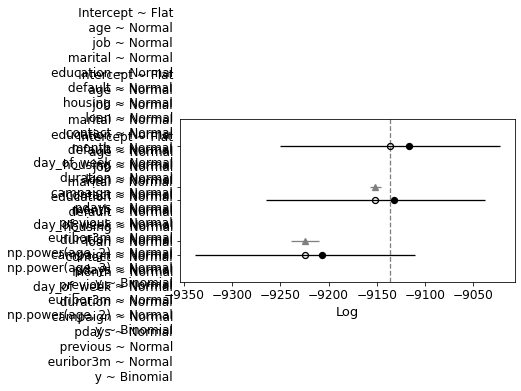

In [69]:
dfwaic = pm.compare(model_trace_dict, ic='WAIC')
print(dfwaic)
pm.compareplot(dfwaic);

In [70]:
dfwaic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
"Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\n day_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\nnp.power(age, 2) ~ Normal\nnp.power(age, 3) ~ Normal\n y ~ Binomial",0,-9136.493381,20.315638,0.000000,0.902506,113.907384,0.000000,False,log
"Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\n day_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\nnp.power(age, 2) ~ Normal\n y ~ Binomial",1,-9151.339736,19.346880,14.846354,0.050198,113.875981,6.120702,False,log
Intercept ~ Flat\n age ~ Normal\n job ~ Normal\n marital ~ Normal\n education ~ Normal\n default ~ Normal\n housing ~ Normal\n loan ~ Normal\n contact ~ Normal\n month ~ Normal\nday_of_week ~ Normal\n duration ~ Normal\n campaign ~ Normal\n pdays ~ Normal\n previous ~ Normal\n euribor3m ~ Normal\n y ~ Binomial,2,-9224.340923,17.777843,87.847542,0.047296,114.121552,14.205236,False,log


**Posterior predictive check**

In [73]:
ppc = pm.sample_posterior_predictive(trace, model=logistic_model, samples=2000)

In [75]:
ppc['y'].mean(axis=0)

array([0.0195, 0.013 , 0.0195, ..., 0.25  , 0.429 , 0.426 ])

In [76]:
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

In [77]:
def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

Confusion matrix
[[35641   907]
 [ 2852  1788]]


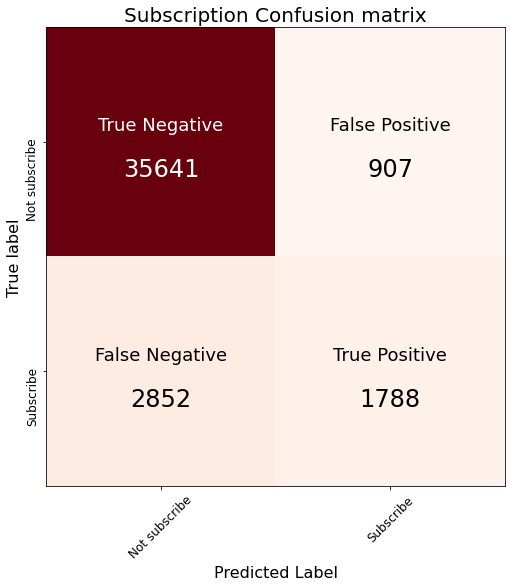

In [78]:
cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [79]:
print('Accuracy of the full model: ', accuracy_score(preds, data['outcome']))
print('f1 score of the full model: ', f1_score(preds, data['outcome']))

Accuracy of the full model:  0.9087355540448674
f1 score of the full model:  0.4875255623721881
